# Cascade分類器
以下將介紹如何使用opencv提供的工具進行標註、產生資料及訓練模型。

## 資料集
接下來將使用的包含正面樣本的att_faces資料集及負面樣本的資料集。<br>
att_faces資料集為AT&T Laboratories Cambridge提供的資料集。其中包含40個人，每個人皆有10張不同的照片，共有40×10＝400張圖片。每張圖片為92×112的灰階影像。<br>
由於正面資料集需花費大量時間進行標記，因此只使用其中的50張影像。負面樣本為不包含正面樣本且大小為大於使用者自訂的影像尺寸即可，在此使用的是交通標誌資料集，共有80張。<br>

## Cascade訓練
我們將使用opencv所提供的`opencv_annotation`、`opencv_createsamples`、`opencv_traincascade`分別進行資料標註、產生資料及資料訓練。

首先將目錄切會到教材所在的資料夾位置，以方便後續程式執行。

In [6]:
# Change directory
%cd assets/
%pwd

C:\Users\User\Desktop\ical\ai_training\0722_OpenCV\3-Haar-Trainning\assets


'C:\\Users\\User\\Desktop\\ical\\ai_training\\0722_OpenCV\\3-Haar-Trainning\\assets'

首先需要將你的資料集分為兩類：包含辨識目標的正面樣本以及不包含的負面樣本。
我們使用交通號誌的影像作為接下來教學用的資料集，其正面及負面樣本分別位於`traffic_light_dataset/`中的`pos/`以及`neg/`中

接著我們需要於我們的正面樣本中，將目標物件給框選出來。
使用的為`opencv_annotation`此程式，輸入指令如下。

In [8]:
# Usage: opencv_annotation.exe --annotations=<path of the output annotation file> --images=<directory of the positive images>
!bin\opencv_annotation.exe --annotations=pos_ical.dat --images=database/

* mark rectangles with the left mouse button,
* press 'c' to accept a selection,
* press 'd' to delete the latest selection,
* press 'n' to proceed with next image,
* press 'esc' to stop.


若執行順利，畫面上會出現你的正面樣本依序出現在畫面上。程式操作方式如下：
- 滑鼠左鍵點擊：對物件進行框選（框選的區域會以紅色矩形顯示）  
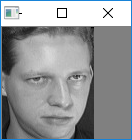
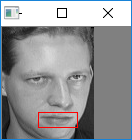
- 鍵盤c鍵：確認框選的內容（確認後框選區域會由紅色轉變為綠色）  
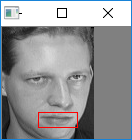
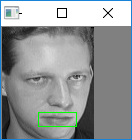
- 鍵盤d鍵：刪除最近一次框選的內容
- 鍵盤n鍵：切換至下一張影像
- 鍵盤esc鍵：停止程式

標記完成後，於`--annotations`中指定的位置會出現你輸出的標註檔案。
此檔案內容每一行為一張正面樣本，其格式如下：
```dat
<正面樣本名稱> <框選數量> <第1個物件x位置> <第1個物件y位置> <第1個物件寬> <第1個物件高> ....
```

接下來使用`opencv_createsamples`產生opencv所使用的二進位檔案，輸入指令如下：

In [10]:
#Usage: opencv_createsamples.exe -info <annotation file> -vec <output binary file> -num <number of samples> -w <sample width> -h <sample height>
!bin\opencv_createsamples.exe -info pos_ical.dat -vec pos_ical.vec -num 240 -w 24 -h 24

Info file name: pos_ical.dat
Img file name: (NULL)
Vec file name: pos_ical.vec
BG  file name: (NULL)
Num: 240
BG color: 0
BG threshold: 80
Invert: FALSE
Max intensity deviation: 40
Max x angle: 1.1
Max y angle: 1.1
Max z angle: 0.5
Show samples: FALSE
Width: 24
Height: 24
Max Scale: -1
Create training samples from images collection...
Done. Created 240 samples


執行成功後，於`-vec`中指定的位置會出現你輸出的二進位檔案。

到這個步驟已經將所有正面樣本處理完畢，接下來為負面樣本的部分。負面樣本的格式為檔案內每一行描述負面樣本所在的位置，其格式如下：
```txt
<path to negative sample1>
<path to negative sample2>
<path to negative sample3>
...
```

接下來將`traffic_light_dataset/neg/`中的負面樣本轉換為上述格式。

In [2]:
import glob

with open('neg.dat', 'w') as file:
    paths = glob.glob('att_faces/neg/*')
    for i in paths:
        file.write('{0}\n' .format(i))

輸出檔案為`neg.dat`，其內容為全部負面樣本的位置。至此所有樣本皆處理完成。

接下來，使用`opencv_traincascade`進行訓練，輸入指令如下：

In [3]:
#Usage: opencv_traincascade.exe -data <output_dir> -vec <positive binary file> -bg <negative txt> \
#                -numPos <number of positive samples> -numNeg <number of negative samples> -numStages <number of stages> -featureType <HAAR|LBP|HOG>
!bin\opencv_traincascade.exe -data ical_model/ -vec pos_ical.vec -bg neg.dat -numPos 240 -numNeg 80 -numStages 24 -featureType HAAR

The system cannot find the path specified.


訓練完成後，於`haar_model/cascade.xml`即為最終的模型。<br>
其xml檔案的內容如下：  
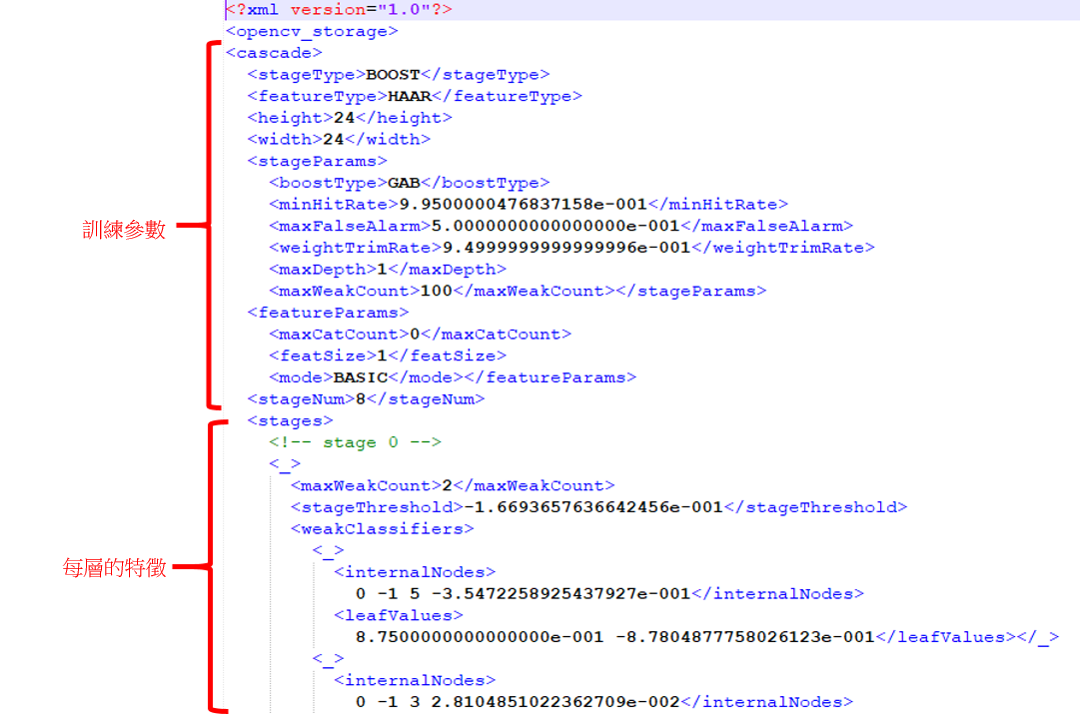

接著訓練出一個LBP cascade分類器。

In [4]:
!bin\opencv_traincascade.exe -data lbp_model/ -vec pos.vec -bg neg.dat -numPos 50 -numNeg 80 -numStages 10 -featureType LBP

The system cannot find the path specified.


到此步驟已經訓練完HAAR及LBP模型，接著接續前面單元的辨識程式，使用自己訓練的模型及影像，將HAAR及LBP的辨識結果顯示於螢幕上。

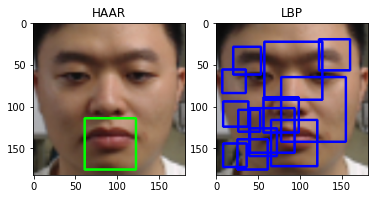

In [14]:
import cv2 as cv
import matplotlib.pyplot as plt

haar_path = "haar_ical_model/cascade.xml"
lbp_path = "lbp_model/cascade.xml"
#img_path = "att_faces/pos/0.jpg"
img_path = "test/photo_2017_05_04_13_40_20_0_3.png"

# Load model
haar_cascade_classifier = cv.CascadeClassifier(haar_path)
lbp_cascade_classifier = cv.CascadeClassifier(lbp_path)

if(haar_cascade_classifier.empty()):
    print('load haar cascade classifier error')
if(lbp_cascade_classifier.empty()):
    print('load lbp cascade classifier error')

# Read image
image = cv.imread(img_path)
if(image is None):
    print('read image error')
else:
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)


haar_results = haar_cascade_classifier.detectMultiScale(gray)
lbp_results = lbp_cascade_classifier.detectMultiScale(gray)

# Draw results
haar_img = image.copy()
lbp_img = image.copy()
for (x, y, w, h) in haar_results:
    haar_img = cv.rectangle(haar_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
for (x, y, w, h) in lbp_results:
    lbp_img = cv.rectangle(lbp_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Show results
haar_img = cv.cvtColor(haar_img, cv.COLOR_BGR2RGB)
lbp_img = cv.cvtColor(lbp_img, cv.COLOR_BGR2RGB)
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.title('HAAR')
plt.imshow(haar_img)
fig.add_subplot(1, 2, 2)
plt.title('LBP')
plt.imshow(lbp_img)
plt.show()